In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
# from keras import layers, Dense, Input, InputLayer, Flatten
# from keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras.utils.generic_utils import get_custom_objects
%matplotlib inline

In [5]:
list = [0, 40, 80, 120, 160, 200]
print(list)

[0, 40, 80, 120, 160, 200]


In [7]:
IMG_WIDTH=512
IMG_HEIGHT=288

In [10]:
# data preprocessing

from tensorflow.python.ops.math_ops import segment_max
import sys
def create_dataset(img_folder, mask_folder, n_class):
   
    img_data=[]
    img_mask=[]
    for dir1 in os.listdir(img_folder):
        # print(dir1)
        if dir1==".DS_Store":
            continue
        image_path= os.path.join(img_folder, dir1)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data.append(image)

    
        
        mask_path= os.path.join(mask_folder, dir1[:-4] + ".npy")
        image_mask = np.load(mask_path)
        seg_labels = np.zeros((image_mask.shape[0], image_mask.shape[1] ,n_class))
        
        for c in range(3,6):
            seg_labels[:, :, c-3] = (image_mask == list[c]).astype(int)
            # print(len(np.argwhere(seg_labels[:, :, c-3]==1)))
        # print(seg_labels.shape)
        # print(seg_labels.shape)
        seg_labels[:,:,3] = (image_mask < 110).astype(int)
        seg_lab = np.zeros((IMG_HEIGHT, IMG_WIDTH ,  n_class))

        for s in range(n_class):
          seg_lab[:,:,s] = cv2.resize(seg_labels[:,:,s], (IMG_WIDTH, IMG_HEIGHT))

        img_mask.append(seg_lab)
        
    print(np.array(img_mask).shape)
    img_data, img_mask = np.array(img_data), np.array(img_mask).reshape((DATASET_SIZE, IMG_WIDTH * IMG_HEIGHT , n_class))
    return img_data, img_mask

# extract the image array and class name
# extract the image array and class name
DATASET_SIZE = 865
img_data, mask =create_dataset(r'images', r'images_mask',n_class=4)
DATASET_SIZE =100
img_data_valid, mask_valid =create_dataset(r'test_images', r'test_images_mask',n_class=4)
np.save("img_data_288512.npy", img_data)
np.save("mask_288512.npy", mask)
np.save("img_data_valid_288512.npy", img_data_valid)
np.save("mask_valid_288512.npy", mask_valid)


TypeError: 'type' object is not subscriptable

In [7]:
print(img_data.shape)
print(mask.shape)
print(img_data_valid.shape)
print(mask_valid.shape)


(865, 288, 512, 3)
(865, 147456, 4)
(100, 288, 512, 3)
(100, 147456, 4)


In [23]:
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1.e-6):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


# get_custom_objects().update({'dice_coef_loss': Loss(_ReLU)})
def focal_loss(labels, logits, gamma=2.0, alpha=4.0): #[[[]],[[]],[[]],[[]],[[]]]):

    epsilon = 1.e-9
    f_loss_1 = -(alpha * (1-logits)**gamma * labels * K.log(logits + epsilon))
    f_loss_0 = -((logits)**gamma * (1 - labels) * K.log(1 - logits + epsilon))

    f_loss = f_loss_1 + f_loss_0

    # Average over each data point/image in batch
    axis_to_reduce = range(1, K.ndim(f_loss))
    f_loss = K.mean(f_loss, axis=axis_to_reduce)

    return f_loss

def combine_loss(y_true, y_pred):
    return dice_coef_loss(y_true, y_pred) * 0.02 + focal_loss(y_true, y_pred) * 2

In [27]:
## trained model with focal loss + dc
custom_objects = {"dice_coef_loss": dice_coef_loss, "focal_loss": focal_loss, 
            "dice_coef":dice_coef, "combine_loss":combine_loss}
with keras.utils.custom_object_scope(custom_objects):
    model = keras.models.load_model(r'segnet_loss_00481_dice_coef_09077_val_loss_00656_val_dice_coef_09171')
    #(r'model_0005_acc68.h5')

In [1]:
## trained model with Trevsky
from model import segnet
model_test = segnet((288, 512, 3), 4)
model_test.load_weights('segnet_09844_09811.h5')

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-07 16:18:43.926097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-07 16:18:43.926335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Build enceder done..
Build decoder done..


In [6]:
img_data = np.load("training_and_test/prepared_data/img_data_288512.npy")
mask = np.load("training_and_test/prepared_data/mask_288512.npy")
img_data_valid = np.load("training_and_test/prepared_data/img_data_valid_288512.npy")
mask_valid = np.load("training_and_test/prepared_data/mask_valid_288512.npy")

In [7]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)
model.compile()
history = model_test.fit( x=img_data, y=mask,
                validation_data = (np.array(img_data_valid, np.float32),np.array(mask_valid)), validation_freq = 1,
                callbacks=[callback], epochs=1)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

2023-01-16 20:40:32.716566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 17s 3s/step
(100, 147456, 4)
(100, 147456, 4)
14904411
14701966
225842 363157 34765 14166504


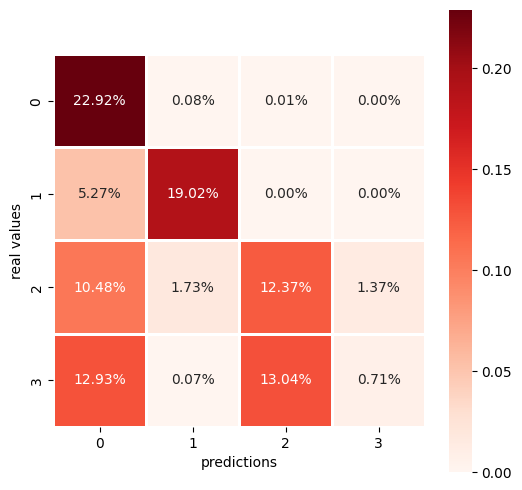

In [28]:
# draw confusion matrix
import seaborn as sns

Y_pred = model.predict(img_data_valid)

# print(img_data[0].shape)
y_pred = np.where(Y_pred >0.3, 1, 0)
y_val = mask_valid.round(1)
print(y_pred.shape)
print(y_val.shape)
print(len(np.argwhere(y_pred == 1)))
print(len(np.argwhere(y_val == 1)))

gt_left = y_val[:,:,0]
mask_left = y_pred[:,:,0]
gt_right = y_val[:,:,1]
mask_right = y_pred[:,:,1]
gt_center = y_val[:,:,2]
mask_center = y_pred[:,:,2]
gt_bg = y_val[:,:,3]
mask_bg = y_pred[:,:,3]

left_num = len(np.argwhere(gt_left) == 1)
right_num = len(np.argwhere(gt_right) == 1)
center_num = len(np.argwhere(gt_center) == 1)
bg_num = len(np.argwhere(gt_bg) == 1)
# print(gt_center.shape())
print(left_num, right_num, center_num, bg_num)

p0v0 = len(np.where(mask_bg + gt_bg == 2)[0])
p1v0 = len(np.where(mask_left + gt_bg == 2)[0])
p2v0 = len(np.where(mask_right + gt_bg == 2)[0])
p3v0 = len(np.where(mask_center + gt_bg == 2)[0])

p0v1 = len(np.where(mask_bg + gt_left == 2)[0])
p1v1 = len(np.where(mask_left + gt_left == 2)[0])
p2v1 = len(np.where(mask_right + gt_left == 2)[0])
p3v1 = len(np.where(mask_center + gt_left == 2)[0])

p0v2 = len(np.where(mask_bg + gt_right == 2)[0])
p1v2 = len(np.where(mask_left + gt_right == 2)[0])
p2v2 = len(np.where(mask_right + gt_right == 2)[0])
p3v2 = len(np.where(mask_center + gt_right == 2)[0])

p0v3 = len(np.where(mask_bg + gt_center == 2)[0])
p1v3 = len(np.where(mask_left + gt_center == 2)[0])
p2v3 = len(np.where(mask_right + gt_center == 2)[0])
p3v3 = len(np.where(mask_center + gt_center == 2)[0])


cmat = [[p0v0/bg_num, p1v0/bg_num, p2v0/bg_num, p3v0/bg_num], [p0v1/left_num, p1v1/left_num, p2v1/left_num, p3v1/left_num],
        [p0v2/right_num, p1v2/right_num, p2v2/right_num, p3v2/right_num], [p0v3/center_num, p1v3/center_num, p2v3/center_num, p3v3/center_num]]
plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()

(288, 512) 109.267944 0.08307138
(288, 512) 154.58376 0.06120951
(288, 512) 84.52973 0.10587156
(288, 512) 254.71436 10.433851
(288, 512) 97.920265 0.30524653
(288, 512) 155.15454 0.5702237
(288, 512) 85.8648 0.54091626
(288, 512) 253.49445 11.3984375
(288, 512) 105.16118 0.00525726
(288, 512) 164.14462 0.0011939291
(288, 512) 86.41023 0.0028176059
(288, 512) 254.98848 4.082149
(288, 512) 234.10634 0.36246952
(288, 512) 154.20253 0.36284027
(288, 512) 84.52528 0.23977119
(288, 512) 253.29515 13.865454
(288, 512) 223.09692 0.5735956
(288, 512) 152.29353 1.294347
(288, 512) 81.98711 0.88138086
(288, 512) 252.11165 5.6462336
(288, 512) 127.0968 0.026401263
(288, 512) 159.19388 0.009871869
(288, 512) 89.617035 0.020615444
(288, 512) 254.91798 5.814323
(288, 512) 115.301544 0.02891792
(288, 512) 162.36255 0.035063792
(288, 512) 86.29705 0.050879825
(288, 512) 254.8757 6.8039203
(288, 512) 254.06555 0.27708486
(288, 512) 24.794355 0.019986778
(288, 512) 15.504802 0.014433389
(288, 512) 253.7

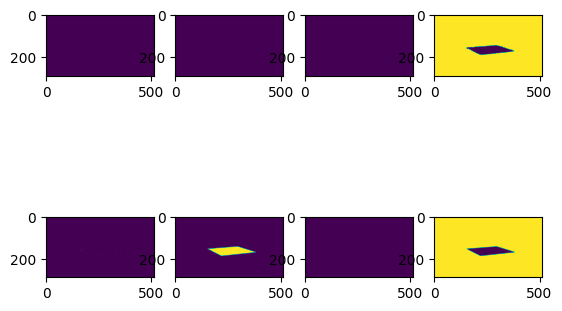

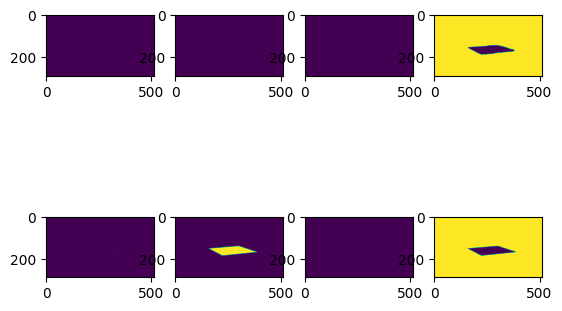

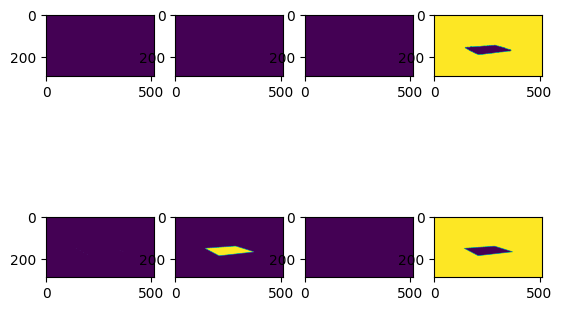

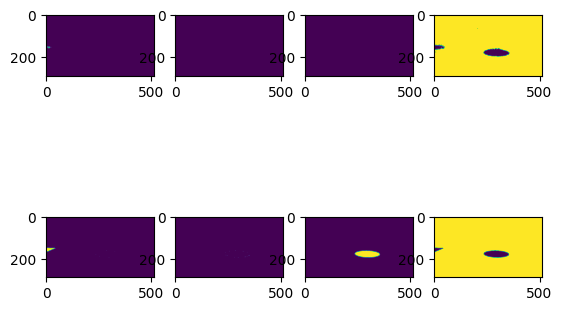

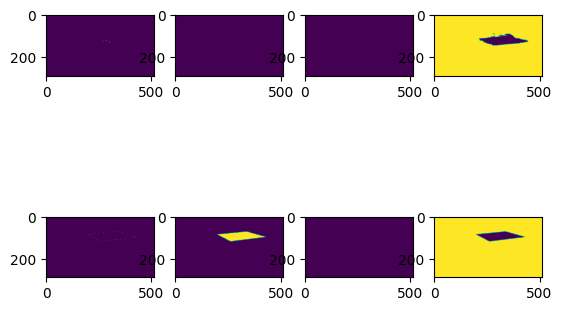

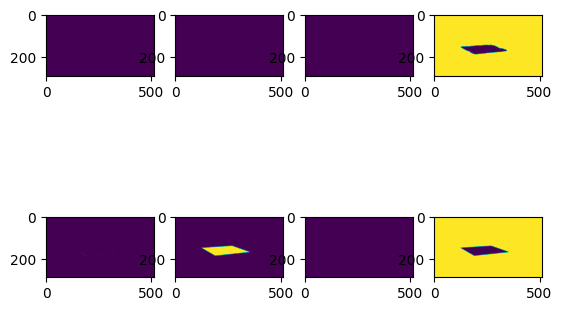

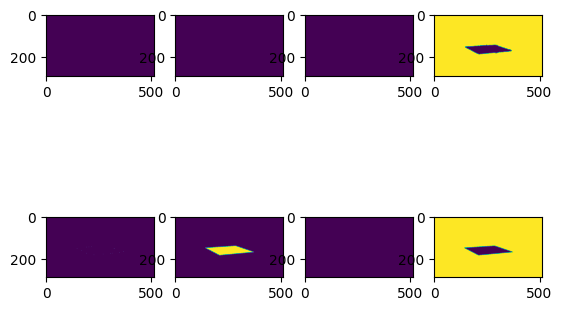

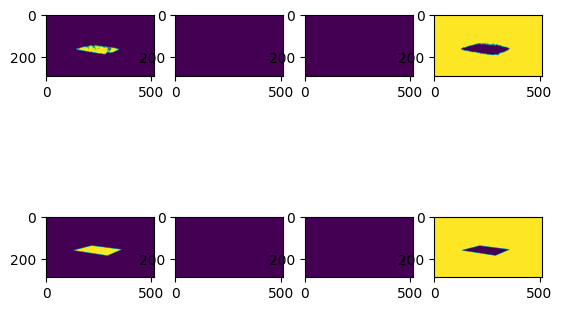

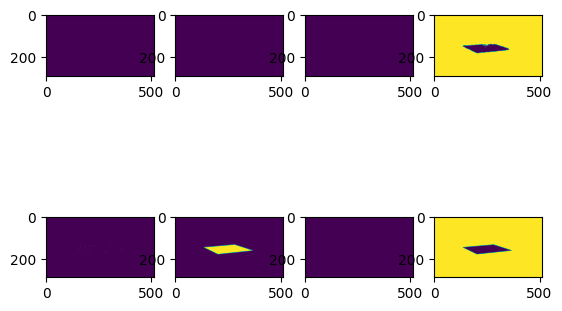

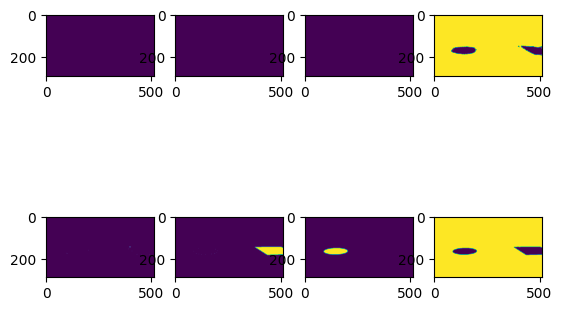

In [30]:
# test predict data
ans = Y_pred.reshape(100, 288, 512, 4)

val = mask_valid.reshape(100, 288, 512, 4)
# cv2.imshow("res",img_data[6])
# cv2.waitKey(0)
# cv2.destroyAllWindows

for pic in range(17, 27):
  fn, ax = plt.subplots(2, 4)
  
  for i in range(4):
      result_img = np.clip(ans[pic,:,:,i], 0, 255)
      result_img *= 255
      
      _, result_img = cv2.threshold(result_img, 200 , 255, cv2.THRESH_BINARY)

      ax[0][i].imshow(result_img)
      ax[1][i].imshow(val[pic,:,:,i])
    # result_img = cv2.resize(result_img, [640,360])
    # cv2.imwrite("output/"+str(i)+".png", result_img)
  
# plt.imshow()